In [1]:
!git clone https://github.com/Kuliah-Machine-Learning/2021-Batik-Kel-2.git

Cloning into '2021-Batik-Kel-2'...
remote: Enumerating objects: 215, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 215 (delta 3), reused 0 (delta 0), pack-reused 203
Receiving objects: 100% (215/215), 4.89 MiB | 30.88 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [2]:
%cd 2021-Batik-Kel-2

/content/2021-Batik-Kel-2


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

In [4]:
#Perintah di bawah ini untuk melihat list bagian dari file yang sudah diunduh dari Github
!ls Dataset/
!ls Dataset/train/Ceplokan
!ls Dataset/train/Kawung
!ls Dataset/train/Lereng
!ls Dataset/train/Segitiga

test  train
Ceplokan_11.jpg  Ceplokan_21.jpg  Ceplokan_31.jpg  Ceplokan_41.jpg
Ceplokan_12.jpg  Ceplokan_22.jpg  Ceplokan_32.jpg  Ceplokan_42.jpg
Ceplokan_13.jpg  Ceplokan_23.jpg  Ceplokan_33.jpg  Ceplokan_43.jpg
Ceplokan_14.jpg  Ceplokan_24.jpg  Ceplokan_34.jpg  Ceplokan_44.jpg
Ceplokan_15.jpg  Ceplokan_25.jpg  Ceplokan_35.jpg  Ceplokan_45.jpg
Ceplokan_16.jpg  Ceplokan_26.jpg  Ceplokan_36.jpg  Ceplokan_46.jpg
Ceplokan_17.jpg  Ceplokan_27.jpg  Ceplokan_37.jpg  Ceplokan_47.jpg
Ceplokan_18.jpg  Ceplokan_28.jpg  Ceplokan_38.jpg  Ceplokan_48.jpg
Ceplokan_19.jpg  Ceplokan_29.jpg  Ceplokan_39.jpg  Ceplokan_49.jpg
Ceplokan_20.jpg  Ceplokan_30.jpg  Ceplokan_40.jpg  Ceplokan_50.jpg
kawung_11.jpg  kawung_19.jpg  kawung_27.jpg  kawung_35.jpg  kawung_43.jpg
kawung_12.jpg  kawung_20.jpg  kawung_28.jpg  kawung_36.jpg  kawung_44.jpg
kawung_13.jpg  kawung_21.jpg  kawung_29.jpg  kawung_37.jpg  kawung_45.jpg
kawung_14.jpg  kawung_22.jpg  kawung_30.jpg  kawung_38.jpg  kawung_46.jpg
kawung_15.jpg  kawung_

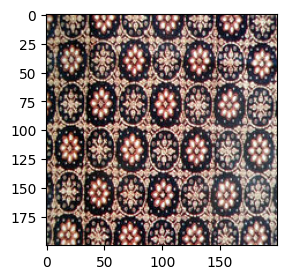

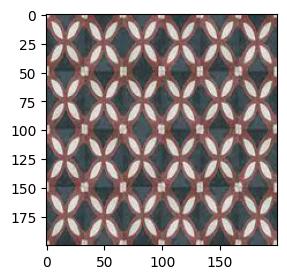

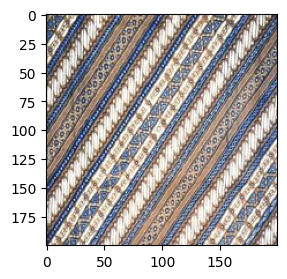

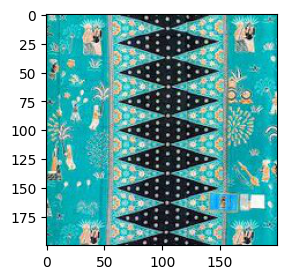

In [17]:
#Perintah untuk memvisualisasikan satu gambar dari data train
image = imread("Dataset/train/Ceplokan/Ceplokan_17.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)
image = imread("Dataset/train/Kawung/kawung_11.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)
image = imread("Dataset/train/Lereng/lereng_36.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)
image = imread("Dataset/train/Segitiga/segitiga_14.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [16]:
#Memuat semua gambar ke memori untuk pertama kali

#Memuat dataset pelatihan
IMAGE_SIZE = 224
BATCH_SIZE = 128
base_dir = os.path.join('Dataset/train')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['Ceplokan', 'Kawung', 'Lereng', 'Segitiga']

for i,label in enumerate(labels):
    folder = os.path.join("Dataset/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 128 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Bentuk array dari dataset train (pelatihan) adalah: (128, 224, 224, 3) (128, 4)
Bentuk array dari dataset validation (validasi) adalah: (32, 224, 224, 3) (32, 4)
Bentuk array dari dataset test (pengujian) adalah: (40, 224, 224, 3) (40,)


In [18]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'Ceplokan': 0, 'Kawung': 1, 'Lereng': 2, 'Segitiga': 3}


In [19]:
!cat labels.txt

Ceplokan
Kawung
Lereng
Segitiga

In [20]:
IMG_SHAPE = (224, 224, 3)
# Membuat model dasar (base model) dari pre-trained model VGG16
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

80150528/80134624 [==============================] - 1s 0us/step


In [21]:
base_model.trainable = False
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [22]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

In [23]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

In [24]:
model = tf.keras.Sequential([
    base_model, 
    #tf.keras.layers.Conv2D(24, 3, activation='relu'),   
    #tf.keras.layers.Conv2D(26, 3, activation='relu'),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    #tf.keras.layers.Dropout(0.2),

    tf.keras.layers.GlobalAveragePooling2D(),
   
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          147488    
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 132       
                                                                 
Total params: 20,172,004
Trainable params: 147,620
Non-trainable params: 20,024,384
_________________________________________________________________


In [25]:
#from keras.callbacks import EarlyStopping, ModelCheckpoint

#Menyimpan file model bobot yang terbaik selama pelatihan (dalam format keras ".h5")
#ckpt = ModelCheckpoint("Klasifikasi Beras Tumpukan.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
history = model.fit_generator(train_generator, 
                    epochs=100, 
                    validation_data=val_generator)
#history = model.fit(x = X_train3, y = y_train3, batch_size=120, epochs= 100,validation_data=(X_valid3,y_valid3),callbacks = [ckpt])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/100
1/1 [==============================] - 103s 103s/step - loss: 1.6070 - acc: 0.2578 - val_loss: 1.3376 - val_acc: 0.3750
Epoch 2/100
1/1 [==============================] - 100s 100s/step - loss: 1.3321 - acc: 0.3203 - val_loss: 1.1724 - val_acc: 0.4688
Epoch 3/100
1/1 [==============================] - 101s 101s/step - loss: 1.1950 - acc: 0.5312 - val_loss: 1.0392 - val_acc: 0.5625
Epoch 4/100
1/1 [==============================] - 100s 100s/step - loss: 1.0841 - acc: 0.5078 - val_loss: 0.9263 - val_acc: 0.6562
Epoch 5/100
1/1 [==============================] - 100s 100s/step - loss: 0.9691 - acc: 0.6641 - val_loss: 0.8091 - val_acc: 0.6875
Epoch 6/100
1/1 [==============================] - 100s 100s/step - loss: 0.8487 - acc: 0.7344 - val_loss: 0.7151 - val_acc: 0.6875
Epoch 7/100
1/1 [==============================] - 102s 102s/step - loss: 0.7654 - acc: 0.7656 - val_loss: 0.6266 - val_acc: 0.8438
Epoch 8/100
1/1 [==============================] - 101s 101s/step - loss: 0.

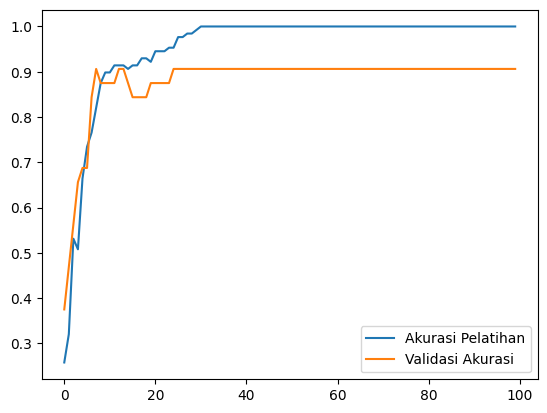

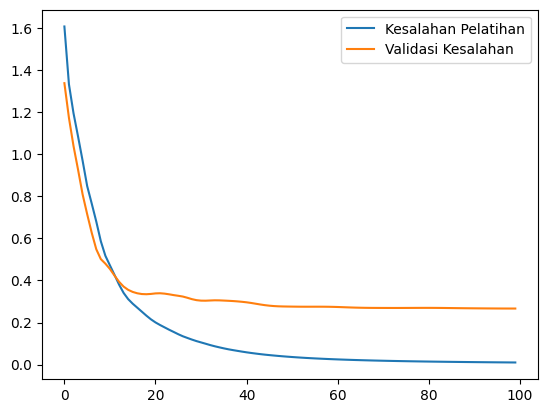

In [26]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

In [27]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


In [28]:
print(train_generator)

In [30]:
#Prediksi Label Validasi dengan Pelatihan
n = 31
input_image = image_batch[n][np.newaxis,...]
print("Labelnya adalah: ", label_batch[n])

predictions = model.predict(input_image)
print("Prediksinya adalah",predictions[0])

Labelnya adalah:  [0. 0. 1. 0.]
Prediksinya adalah [0.19371289 0.7977452  0.00595448 0.00258736]


In [31]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data training
print(model.evaluate(train_generator))
#Evaluasi validasi data
print(model.evaluate(val_generator))
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3)) 

['loss', 'acc']
1/1 [==============================] - 83s 83s/step - loss: 0.0099 - acc: 1.0000
[0.009893355891108513, 1.0]
1/1 [==============================] - 21s 21s/step - loss: 0.2664 - acc: 0.9062
[0.26643577218055725, 0.90625]
2/2 [==============================] - 26s 6s/step - loss: 0.6090 - acc: 0.7500
[0.6089651584625244, 0.75]


In [32]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]
[0 1 0 0 1 1 0 0 2 1 1 1 1 1 1 1 1 1 0 0 0 2 2 2 2 2 2 2 2 1 3 3 3 3 3 3 3
 3 3 0]


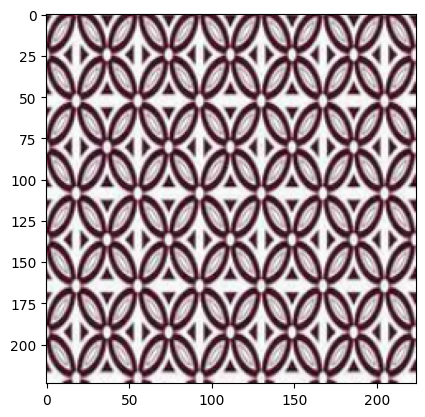

Label yang benar adalah: 1 : Kawung
Nilai yang diprediksi adalah: [0.16161358 0.8251231  0.00908234 0.00418104]
Label yang diprediksi adalah: 1 : Kawung
Prediksi benar


In [43]:
n = 14 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")

Normalized confusion matrix
[[0.5 0.4 0.1 0. ]
 [0.2 0.8 0.  0. ]
 [0.1 0.1 0.8 0. ]
 [0.1 0.  0.  0.9]]


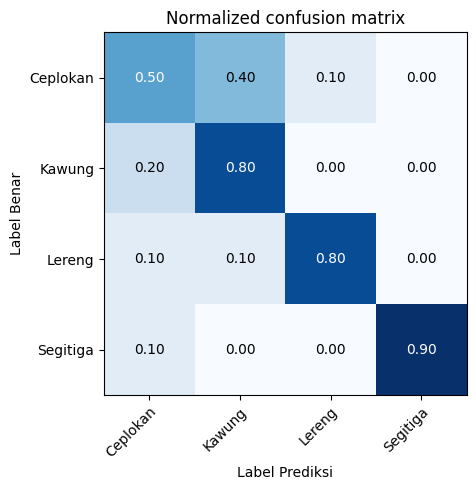

In [44]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

In [45]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('Klasifikasi_2_Jenis_Batik.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: save/model/assets
